
# <span style="color:rgb(213,80,0)">PICMUS challenge: simulation, contrast\-speckle test</span>

This example reads (or downloads if it cannot find the data locally) a dataset used in the [PICMUS challenge](http://ieeexplore.ieee.org/document/7728908/) and beamforms it with USTB's general beamformer. A 75 plane\-wave sequence was simulated with [Field II](http://field-ii.dk/) to estimate the method constrast and speckle statistics.


*by Alfonso Rodriguez\-Molares* [*alfonso.r.molares@ntnu.no*](http://alfonso.r.molares@ntnu.no) *and Olivier Bernard*  [*olivier.bernard@insa\-lyon.fr*](http://olivier.bernard@insa-lyon.fr)

<pre>
 $Last updated: 2017/09/15$
</pre>

In [1]:
close all;clear;clc;
addpath('../functions/');

## Checking if the file is in the local path, and downloading otherwise

In [2]:
% We define the local path and the url where the data is stored
% data location
url='http://ustb.no/datasets/';      % if not found data will be downloaded from here
filename='PICMUS_simulation_contrast_speckle.uff';

% checks if the data is in your data path, and downloads it otherwise.
% The defaults data path is under USTB's folder, but you can change this
% by setting an environment variable with setenv(DATA_PATH,'the_path_you_want_to_use');
tools.download(filename, url, data_path);

## What's inside?

In [3]:
% This dataset should contain the following structures: * channel_data, * beamformed_data and, * scan
% We can check it out with the index function
display=true;
content = uff.index([data_path filesep filename],'/',display);

UFF: Contents of C:\Users\USER\AppData\Roaming\MathWorks\MATLAB Add-Ons\Toolboxes\ustb\data\PICMUS_simulation_contrast_speckle.uff at /
   - /beamformed_data: beamformed_data [uff.beamformed_data] size(1,1)
   - /channel_data: channel_data [uff.channel_data] size(1,1)
   - /scan: scan [uff.linear_scan] size(1,1)

## Plotting beamformed\_data

In [4]:
% We can read the beamformed_data object and plot it
% b_data=uff.read_object([data_path filesep filename],'/beamformed_data');
% b_data.plot();

## Loading channel data & scan

The file also contain channel\_data and scan. We read it so we can replicate the beamformed image in the UFF file.


In [5]:
channel_data=uff.read_object([data_path filesep filename],'/channel_data');

UFF: reading channel_data [uff.channel_data]
UFF: reading sequence [uff.wave] [====================] 100%

In [6]:
scan=uff.read_object([data_path filesep filename],'/scan');

## decimating the sequence \-> too heavy for this example

channel\_data.data=channel\_data.data(:,:,38); channel\_data.sequence=channel\_data.sequence(38);


In [7]:
% set pulse center frequency
channel_data.pulse=uff.pulse(center_frequency=5.208e6);

## Beamforming

In [8]:
% % We define a beamformer, and the corresponding transmit and apodization % windows, and launch it.
% pipe=pipeline(); pipe.channel_data=channel_data; pipe.scan=scan;
% receive apodization pipe.receive_apodization.window=uff.window.tukey50; pipe.receive_apodization.f_number=1.7;
% transmit apodization pipe.transmit_apodization.window=uff.window.tukey50; pipe.transmit_apodization.f_number=1.7;
% launch beamforming b_data_new=pipe.go({midprocess.das postprocess.coherent_compounding});

## Set up processing pipeline / Delay the channel data

In [9]:
% We are using no apodization because the SLSC algorithm requires equally weighted channel data from all receive elements
mid=midprocess.das();
mid.dimension = dimension.transmit;

mid.channel_data=channel_data;
mid.scan=scan;

% mid.transmit_apodization.window=uff.window.scanline;
mid.transmit_apodization.window=uff.window.none;
mid.receive_apodization.window=uff.window.none;

% This will result in a beamformed_data object with the delayed and not
% summed channel data.
b_data = mid.go();

USTB MEX C beamformer...Completed in 6.88 seconds.

## Create the Delay\-And\-Sum image

In [10]:
% If we want the DAS image, we can simply sum them.
das = postprocess.coherent_compounding();
das.input = b_data;
das_image = das.go();
% figure(1);
% das_image.plot(subplot(121),['DAS'],60,'log'); % 'none' instead of 'log' to get iq
% das_image.plot([],['DAS'],60,'log'); % 'none' instead of 'log' to get iq

% iq=b_data.get_image();   % no funciona, usar das_image para get_image()
iq=das_image.get_image('none');
env_rf=abs(iq);

## log comp and plot DAS


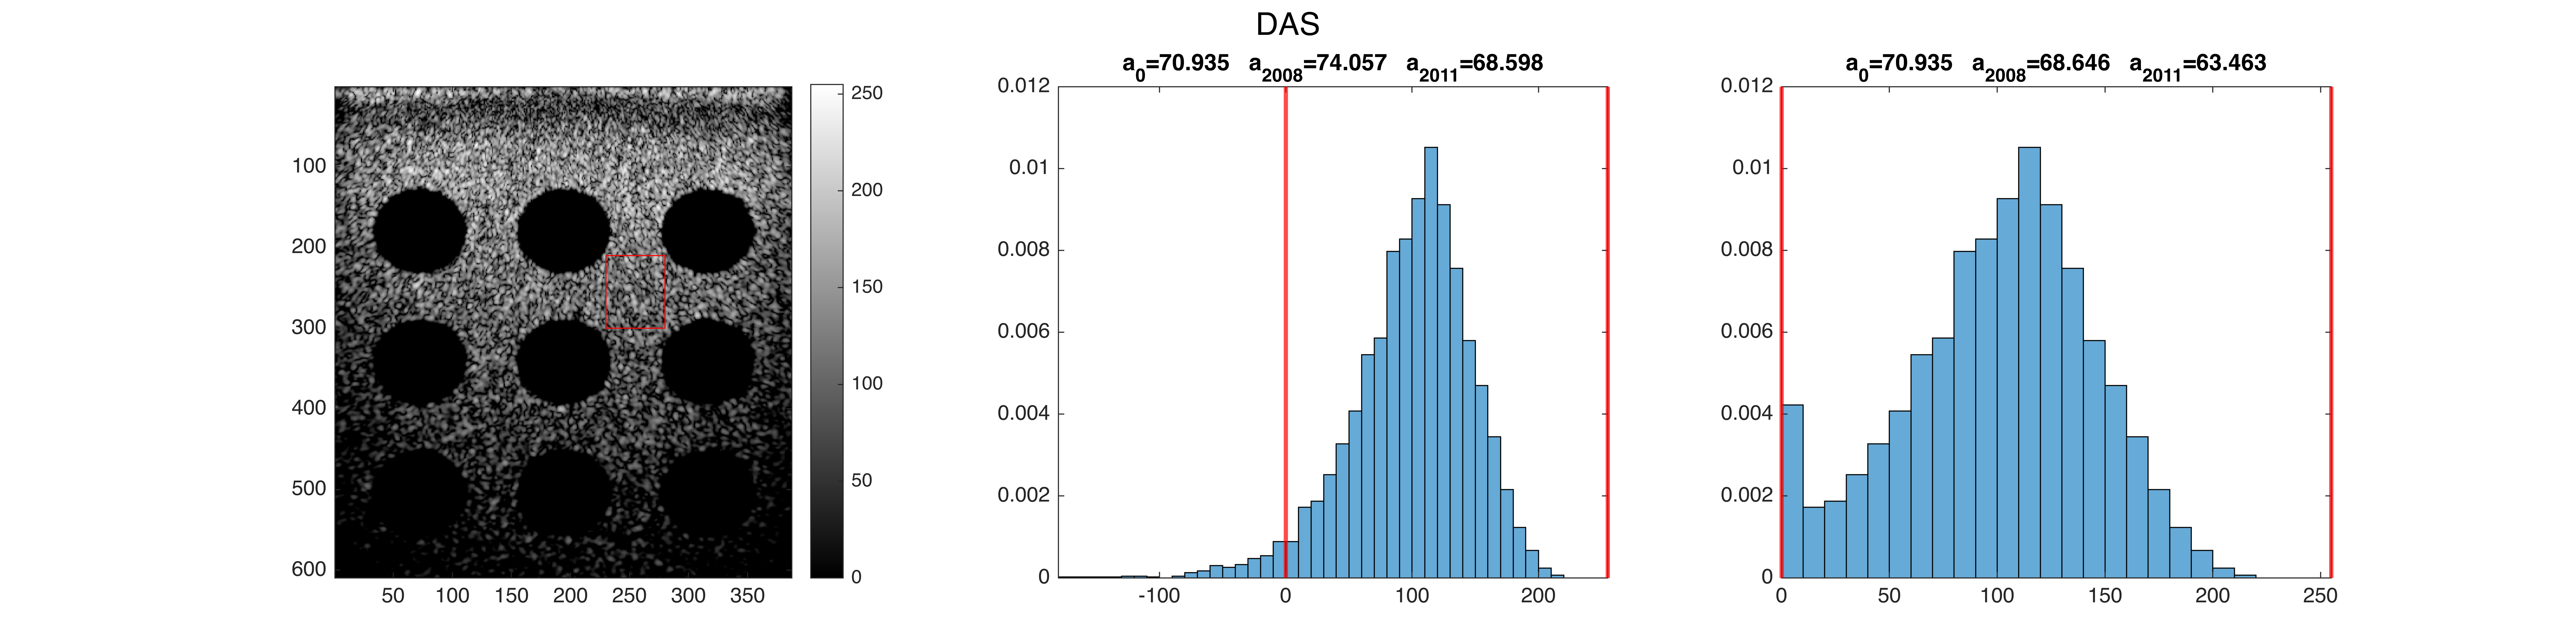

In [11]:
lims = [230 210 280 300]; % limits for ROI

[a,b,comp_env] = getab(env_rf);
comp_env_png=comp_env.*(comp_env>0);

n_seabra2011=11;
env_wind=comp_env(lims(2):lims(4), lims(1):lims(3));
[a_seabra2008,~] = est_seabra2008(env_wind,a,b);
[a_seabra2011,~] = est_seabra2011(env_wind,a,b,n_seabra2011);

env_wind_png=comp_env_png(lims(2):lims(4), lims(1):lims(3));
[a_seabra2008_png,~] = est_seabra2008(env_wind_png,a,b);
[a_seabra2011_png,~] = est_seabra2011(env_wind_png,a,b,n_seabra2011);

f=figure;f.Position=f.Position.*[0 0 3 1];
subplot(1,3,1);
imagesc(comp_env);colormap gray;colorbar;clim([0 255]);hold on;
rectangle(Position=[lims(1:2) lims(3)-lims(1) lims(4)-lims(2)],EdgeColor='r'); % [x y w h]

subplot(1,3,2);
histogram(env_wind,Normalization='pdf');hold on;
xline(0,Color='r',LineWidth=2);xline(255,Color='r',LineWidth=2);xlim([-inf 255]);
title(['a_0=',num2str(a,5),'   a_{2008}=',num2str(a_seabra2008,5),'   a_{2011}=',num2str(a_seabra2011,5)]);

subplot(1,3,3);
histogram(env_wind_png,Normalization='pdf');hold on;
xline(0,Color='r',LineWidth=2);xline(255,Color='r',LineWidth=2);xlim([-inf 255]);
title(['a_0=',num2str(a,5),'   a_{2008}=',num2str(a_seabra2008_png,5),'   a_{2011}=',num2str(a_seabra2011_png,5)]);

sgtitle('DAS');

## Beamform with the GCF (Generalized Coherence Factor)

In [12]:
gcf = postprocess.generalized_coherence_factor();
gcf.dimension = dimension.receive;
gcf.M0 = 4;
gcf.input = b_data;
% gcf.transmit_apodization.window = uff.window.none;
% gcf.receive_apodization.window = uff.window.none;

b_data_gcf=gcf.go();

iq_gcf=b_data_gcf.get_image('none');
env_rf_gcf=abs(iq_gcf);
gcf_map=gcf.GCF.get_image('none');

## log comp and plot GCF


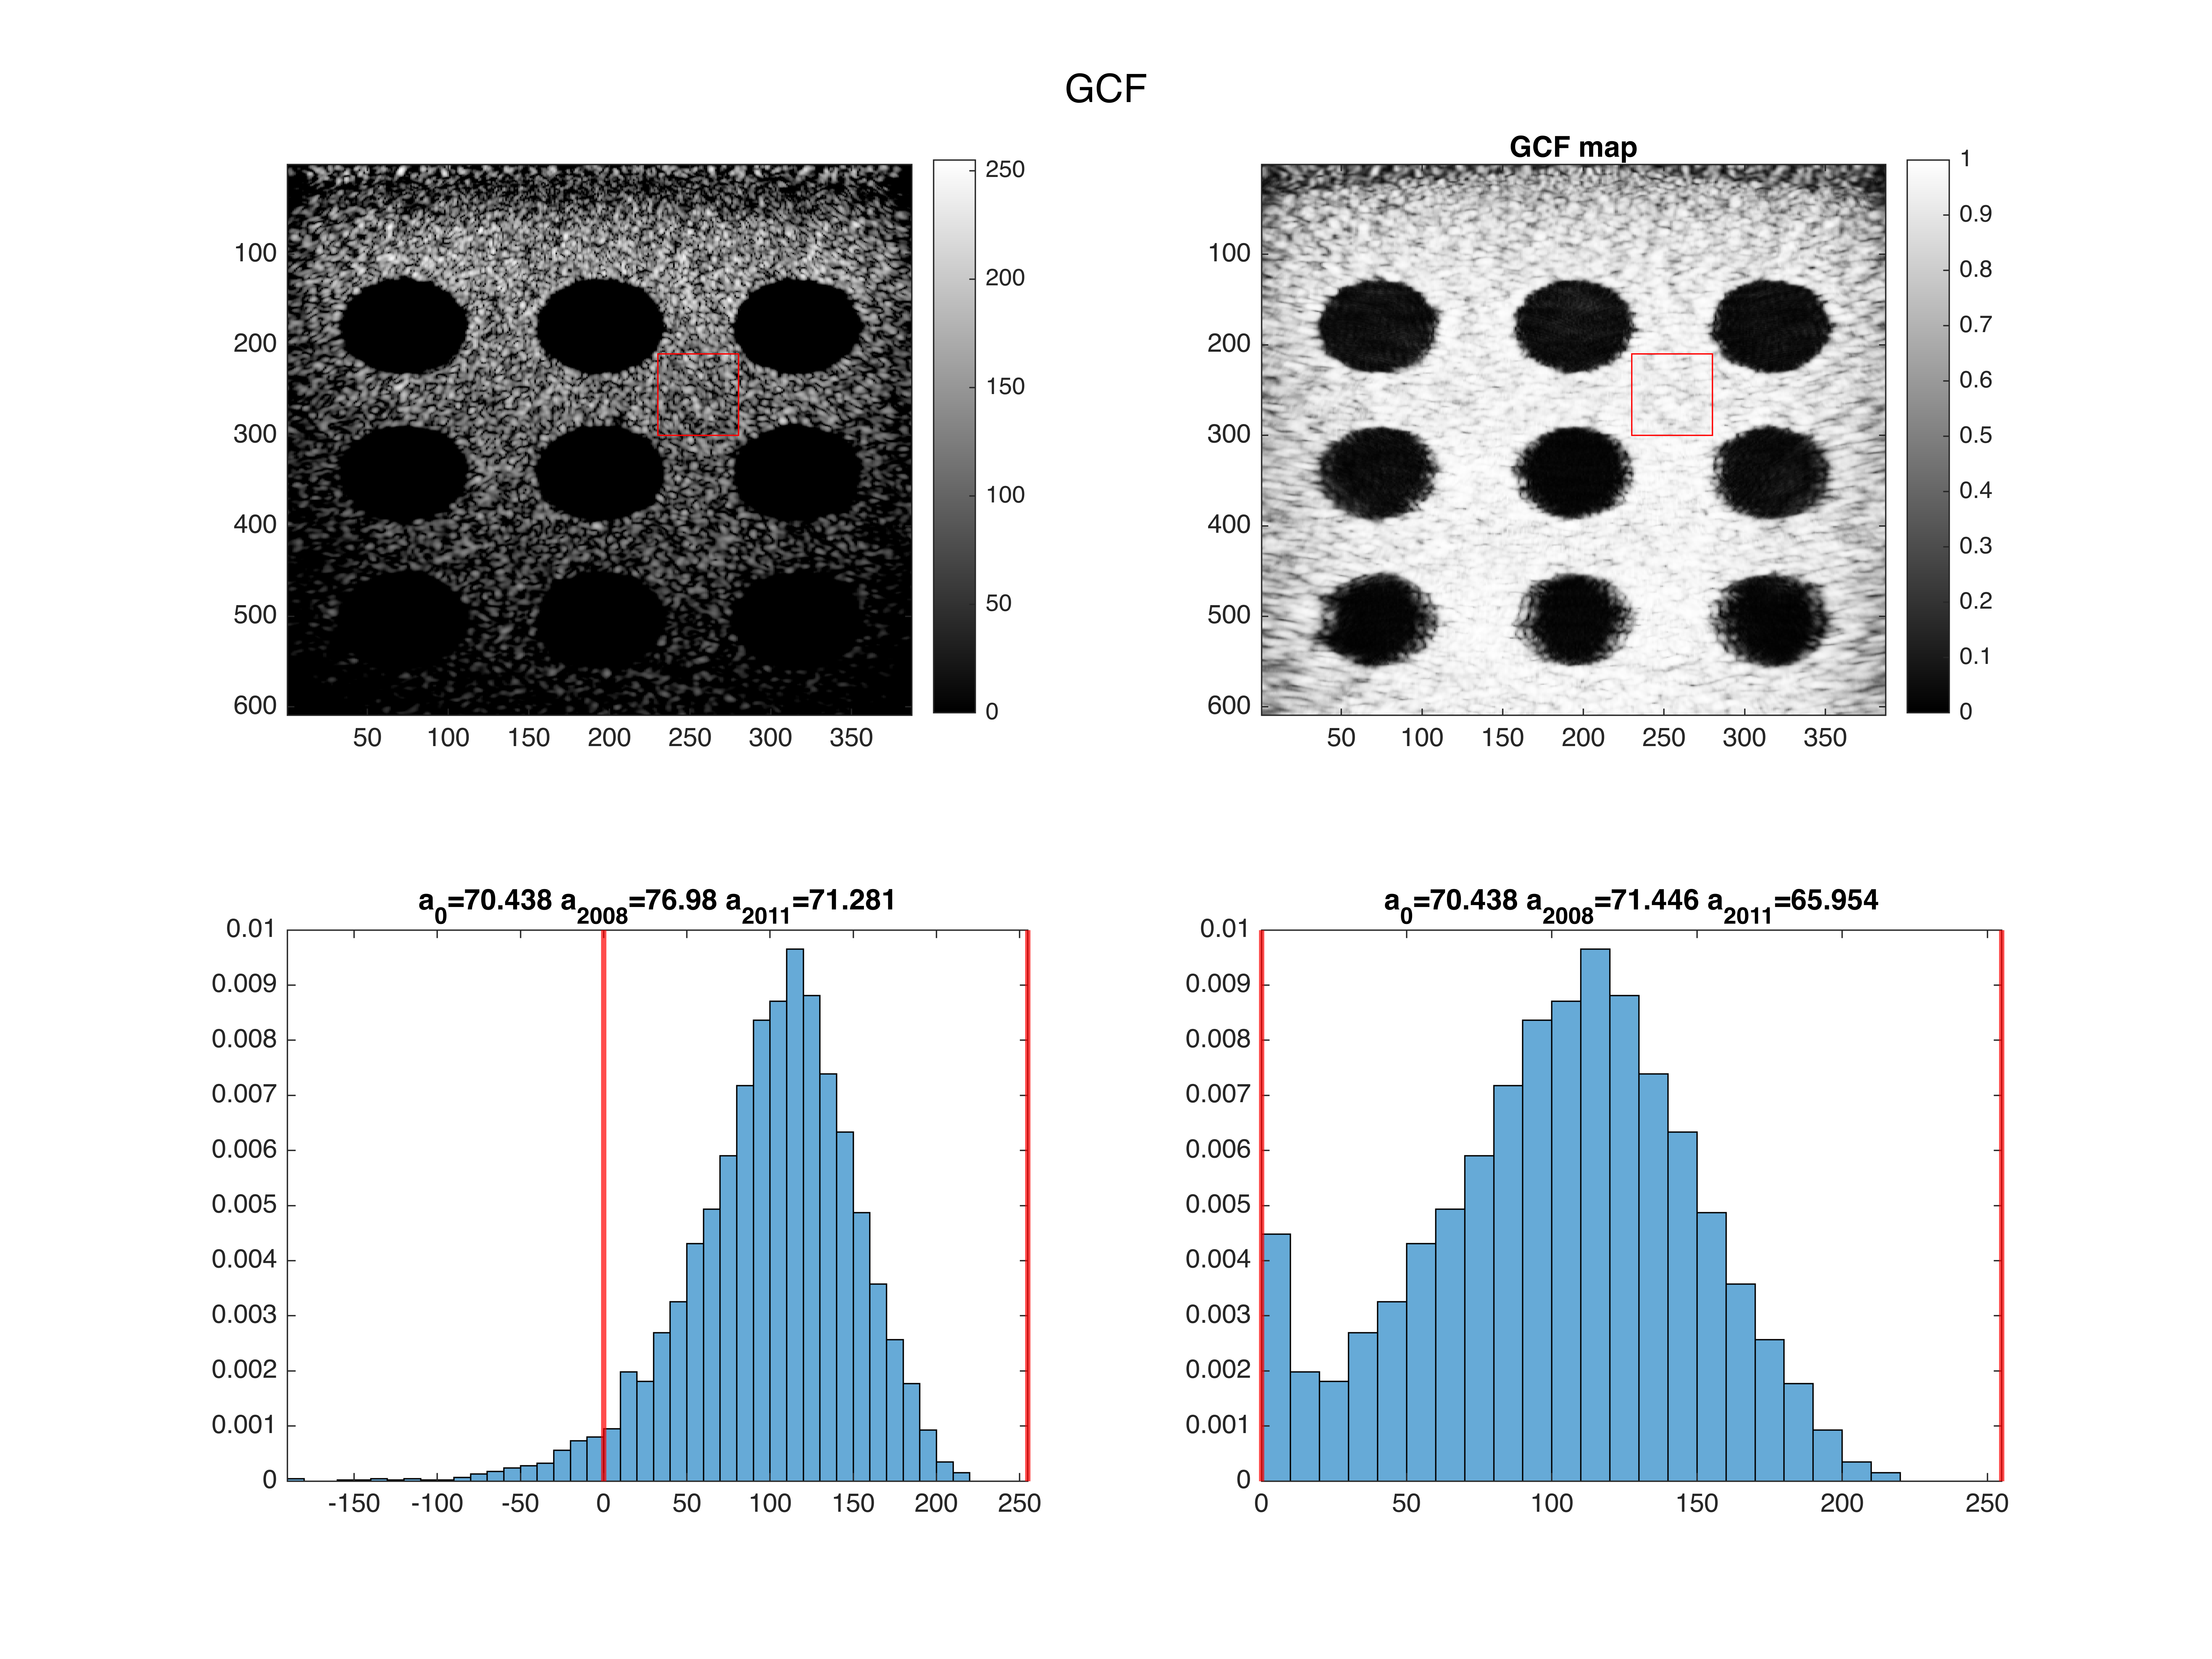

In [13]:
% figure; b_data_gcf.plot(subplot(411),'GCF'); gcf.GCF.plot(subplot(412),'GCF factor',[],['none']);
[a_gcf,b_gcf,comp_env_gcf] = getab(env_rf_gcf);
comp_env_gcf_png=comp_env_gcf.*(comp_env_gcf>0);

n_seabra2011=11;
env_wind_gcf=comp_env_gcf(lims(2):lims(4), lims(1):lims(3));
[a_seabra2008_gcf,~] = est_seabra2008(env_wind_gcf,a_gcf,b_gcf);
[a_seabra2011_gcf,~] = est_seabra2011(env_wind_gcf,a_gcf,b_gcf,n_seabra2011);

env_wind_gcf_png=comp_env_gcf_png(lims(2):lims(4), lims(1):lims(3));
[a_seabra2008_gcf_png,~] = est_seabra2008(env_wind_gcf_png,a,b);
[a_seabra2011_gcf_png,~] = est_seabra2011(env_wind_gcf_png,a,b,n_seabra2011);

f=figure;f.Position=f.Position.*[0 0 2 2];
subplot(2,2,1);
imagesc(comp_env_gcf);colormap gray;colorbar;clim([0 255]);hold on;
rectangle(Position=[lims(1:2) lims(3)-lims(1) lims(4)-lims(2)],EdgeColor='r'); % [x y w h]

subplot(2,2,2);
imagesc(gcf_map);colormap gray;colorbar;clim([0 1]);hold on;
rectangle(Position=[lims(1:2) lims(3)-lims(1) lims(4)-lims(2)],EdgeColor='r'); % [x y w h]
title('GCF map');

subplot(2,2,3);
histogram(env_wind_gcf,Normalization='pdf');hold on;
xline(0,Color='r',LineWidth=2);xline(255,Color='r',LineWidth=2);xlim([-inf 255]);
title(['a_0=',num2str(a_gcf,5),' a_{2008}=',num2str(a_seabra2008_gcf,5),' a_{2011}=',num2str(a_seabra2011_gcf,5)]);

subplot(2,2,4);
histogram(env_wind_gcf_png,Normalization='pdf');hold on;
xline(0,Color='r',LineWidth=2);xline(255,Color='r',LineWidth=2);xlim([-inf 255]);
title(['a_0=',num2str(a_gcf,5),' a_{2008}=',num2str(a_seabra2008_gcf_png,5),' a_{2011}=',num2str(a_seabra2011_gcf_png,5)]);

sgtitle('GCF');

## Create the Short Lag Spatial Coherence (SLSC) image

In [14]:
% We are using a kernel size equal to one wavelength, and use M = 120.
slsc = postprocess.short_lag_spatial_coherence();
slsc.receive_apodization = mid.receive_apodization;
slsc.dimension = dimension.receive;
slsc.channel_data = mid.channel_data;
% slsc.maxM = 10;
slsc.maxM = 120;
slsc.input = b_data;
slsc.K_in_lambda = 1;
slsc_data = slsc.go();

## Histograms
## The reference of the SLSC process

Let's look at the reference for the SLSC process. If you use the USTB and are using the SLSC process in your work you *have* to reference this reference according to our citation policy, see [http://www.ustb.no/citation/](http://www.ustb.no/citation/)


In [15]:
% slsc.print_reference


You can also give some credit to the authors of the implementation in your work ;)


In [16]:
% slsc.print_implemented_by

## Display the SLSC image


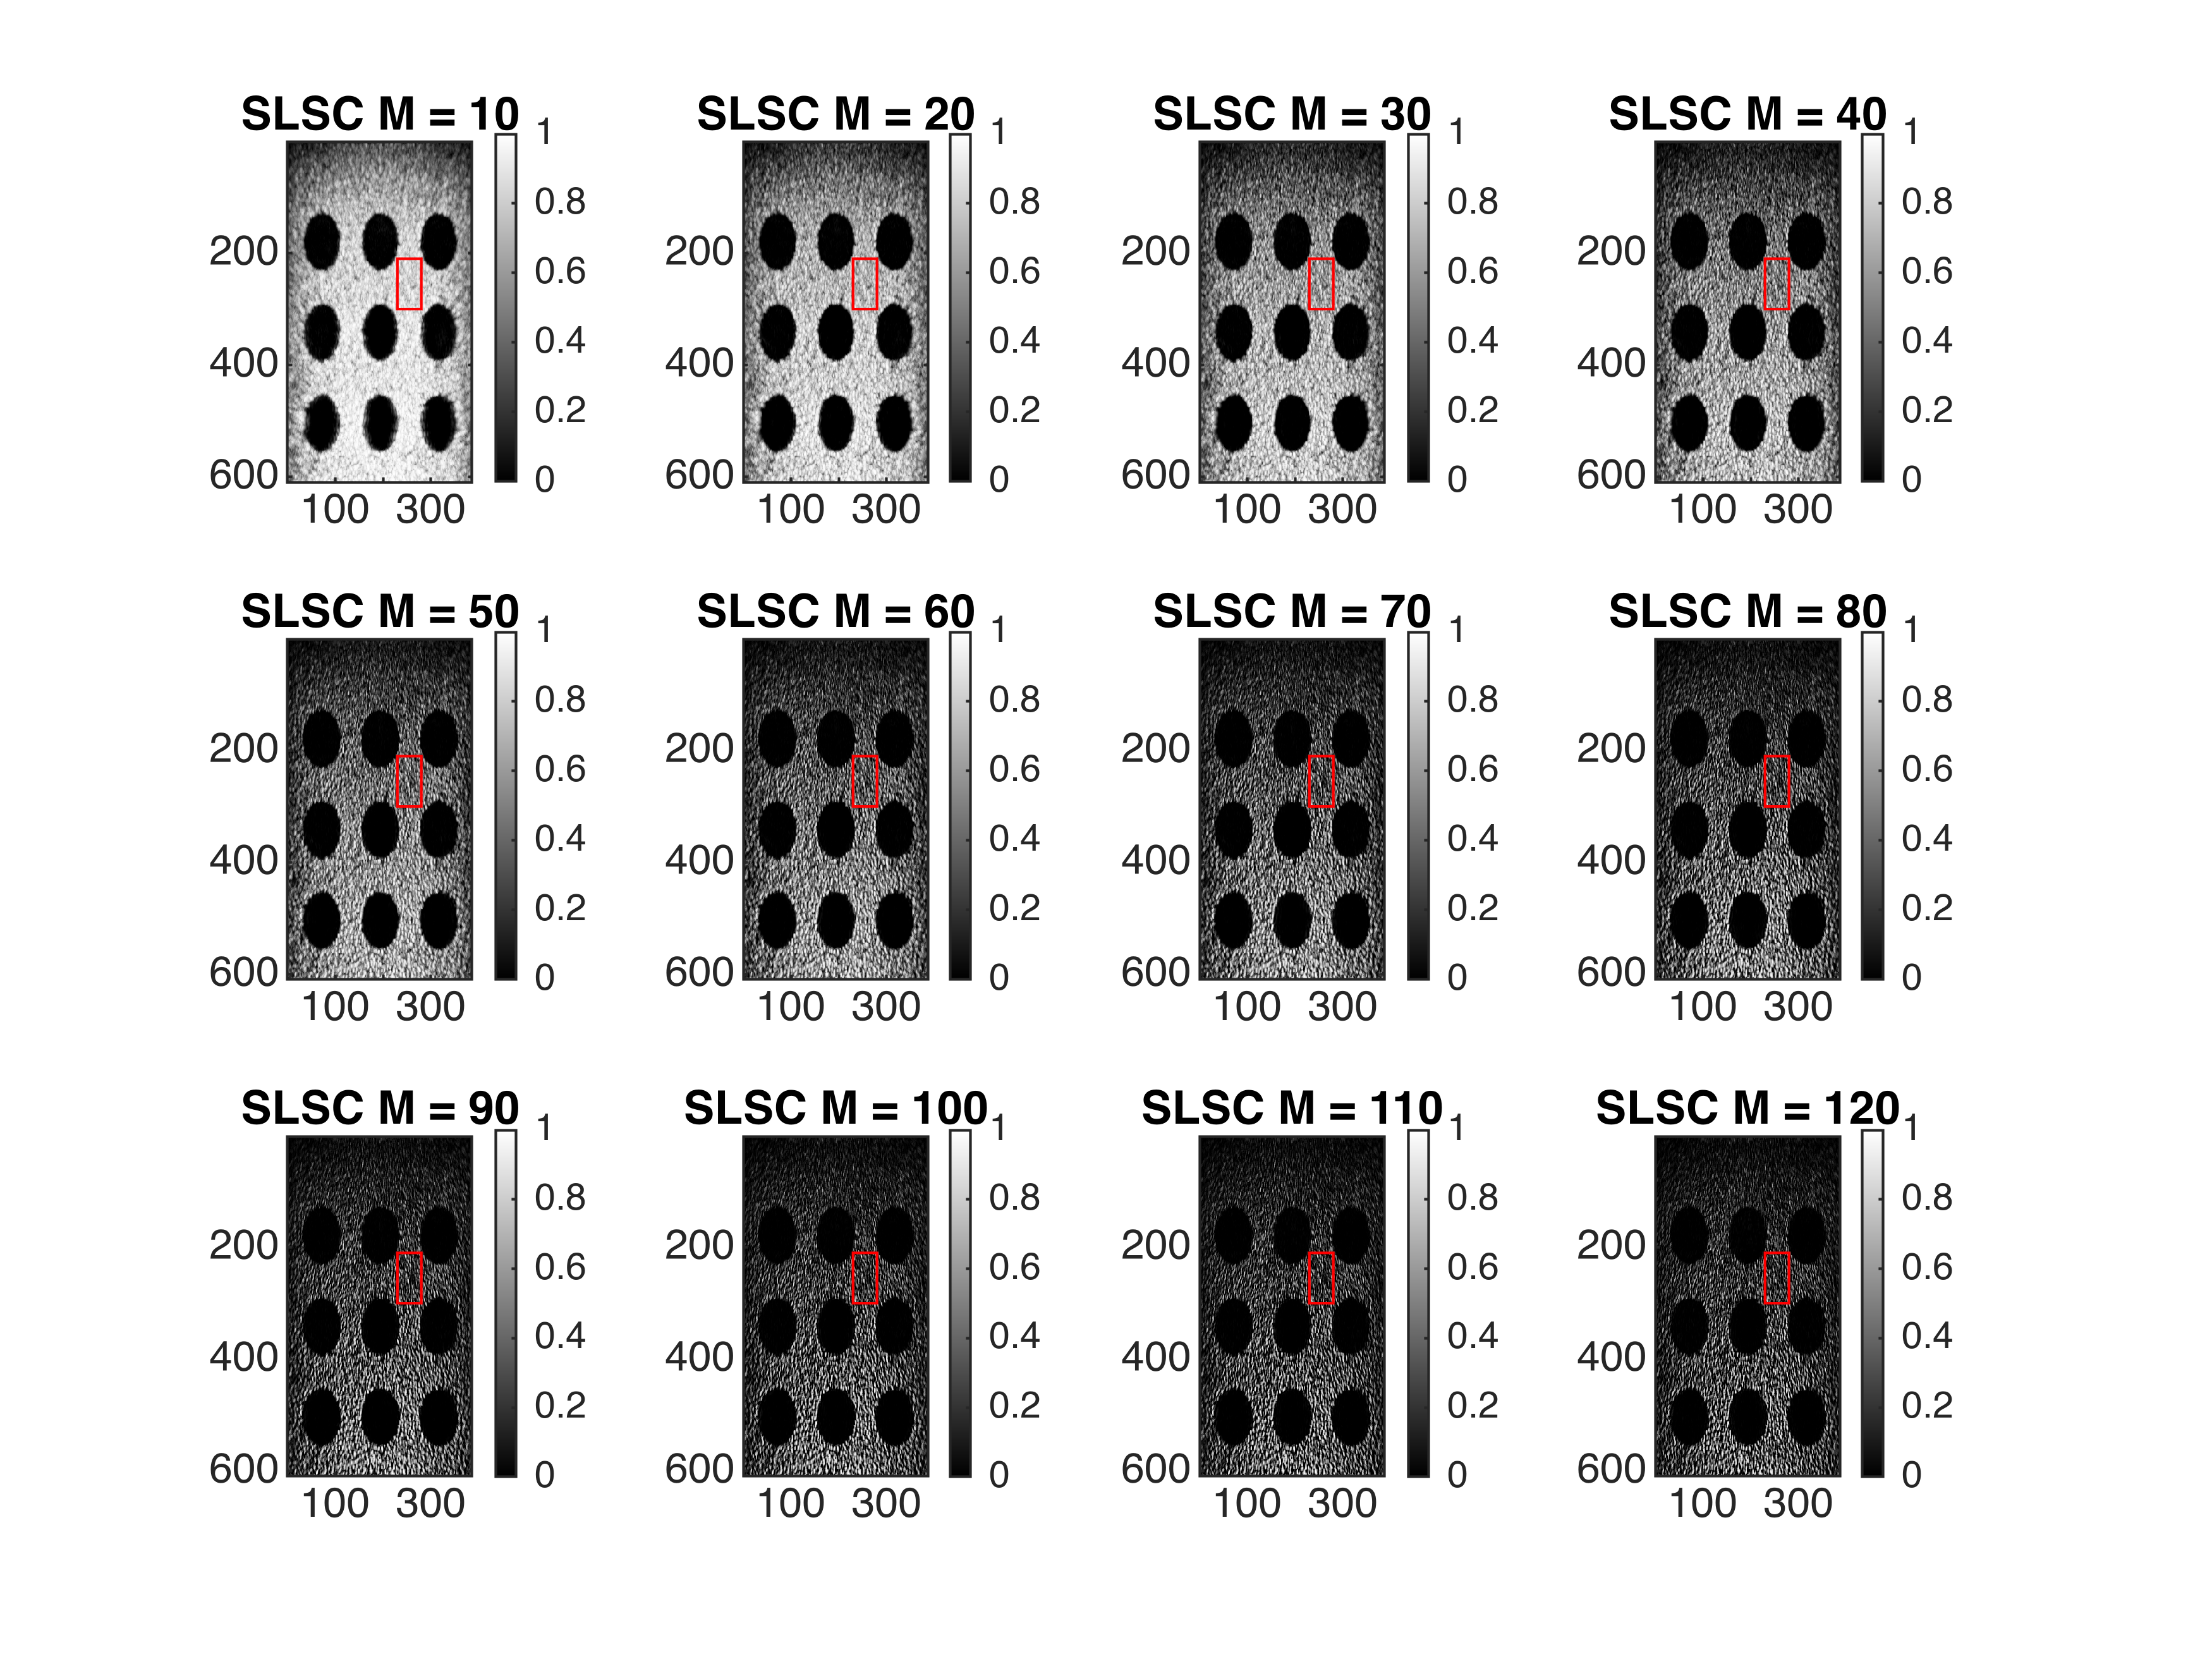


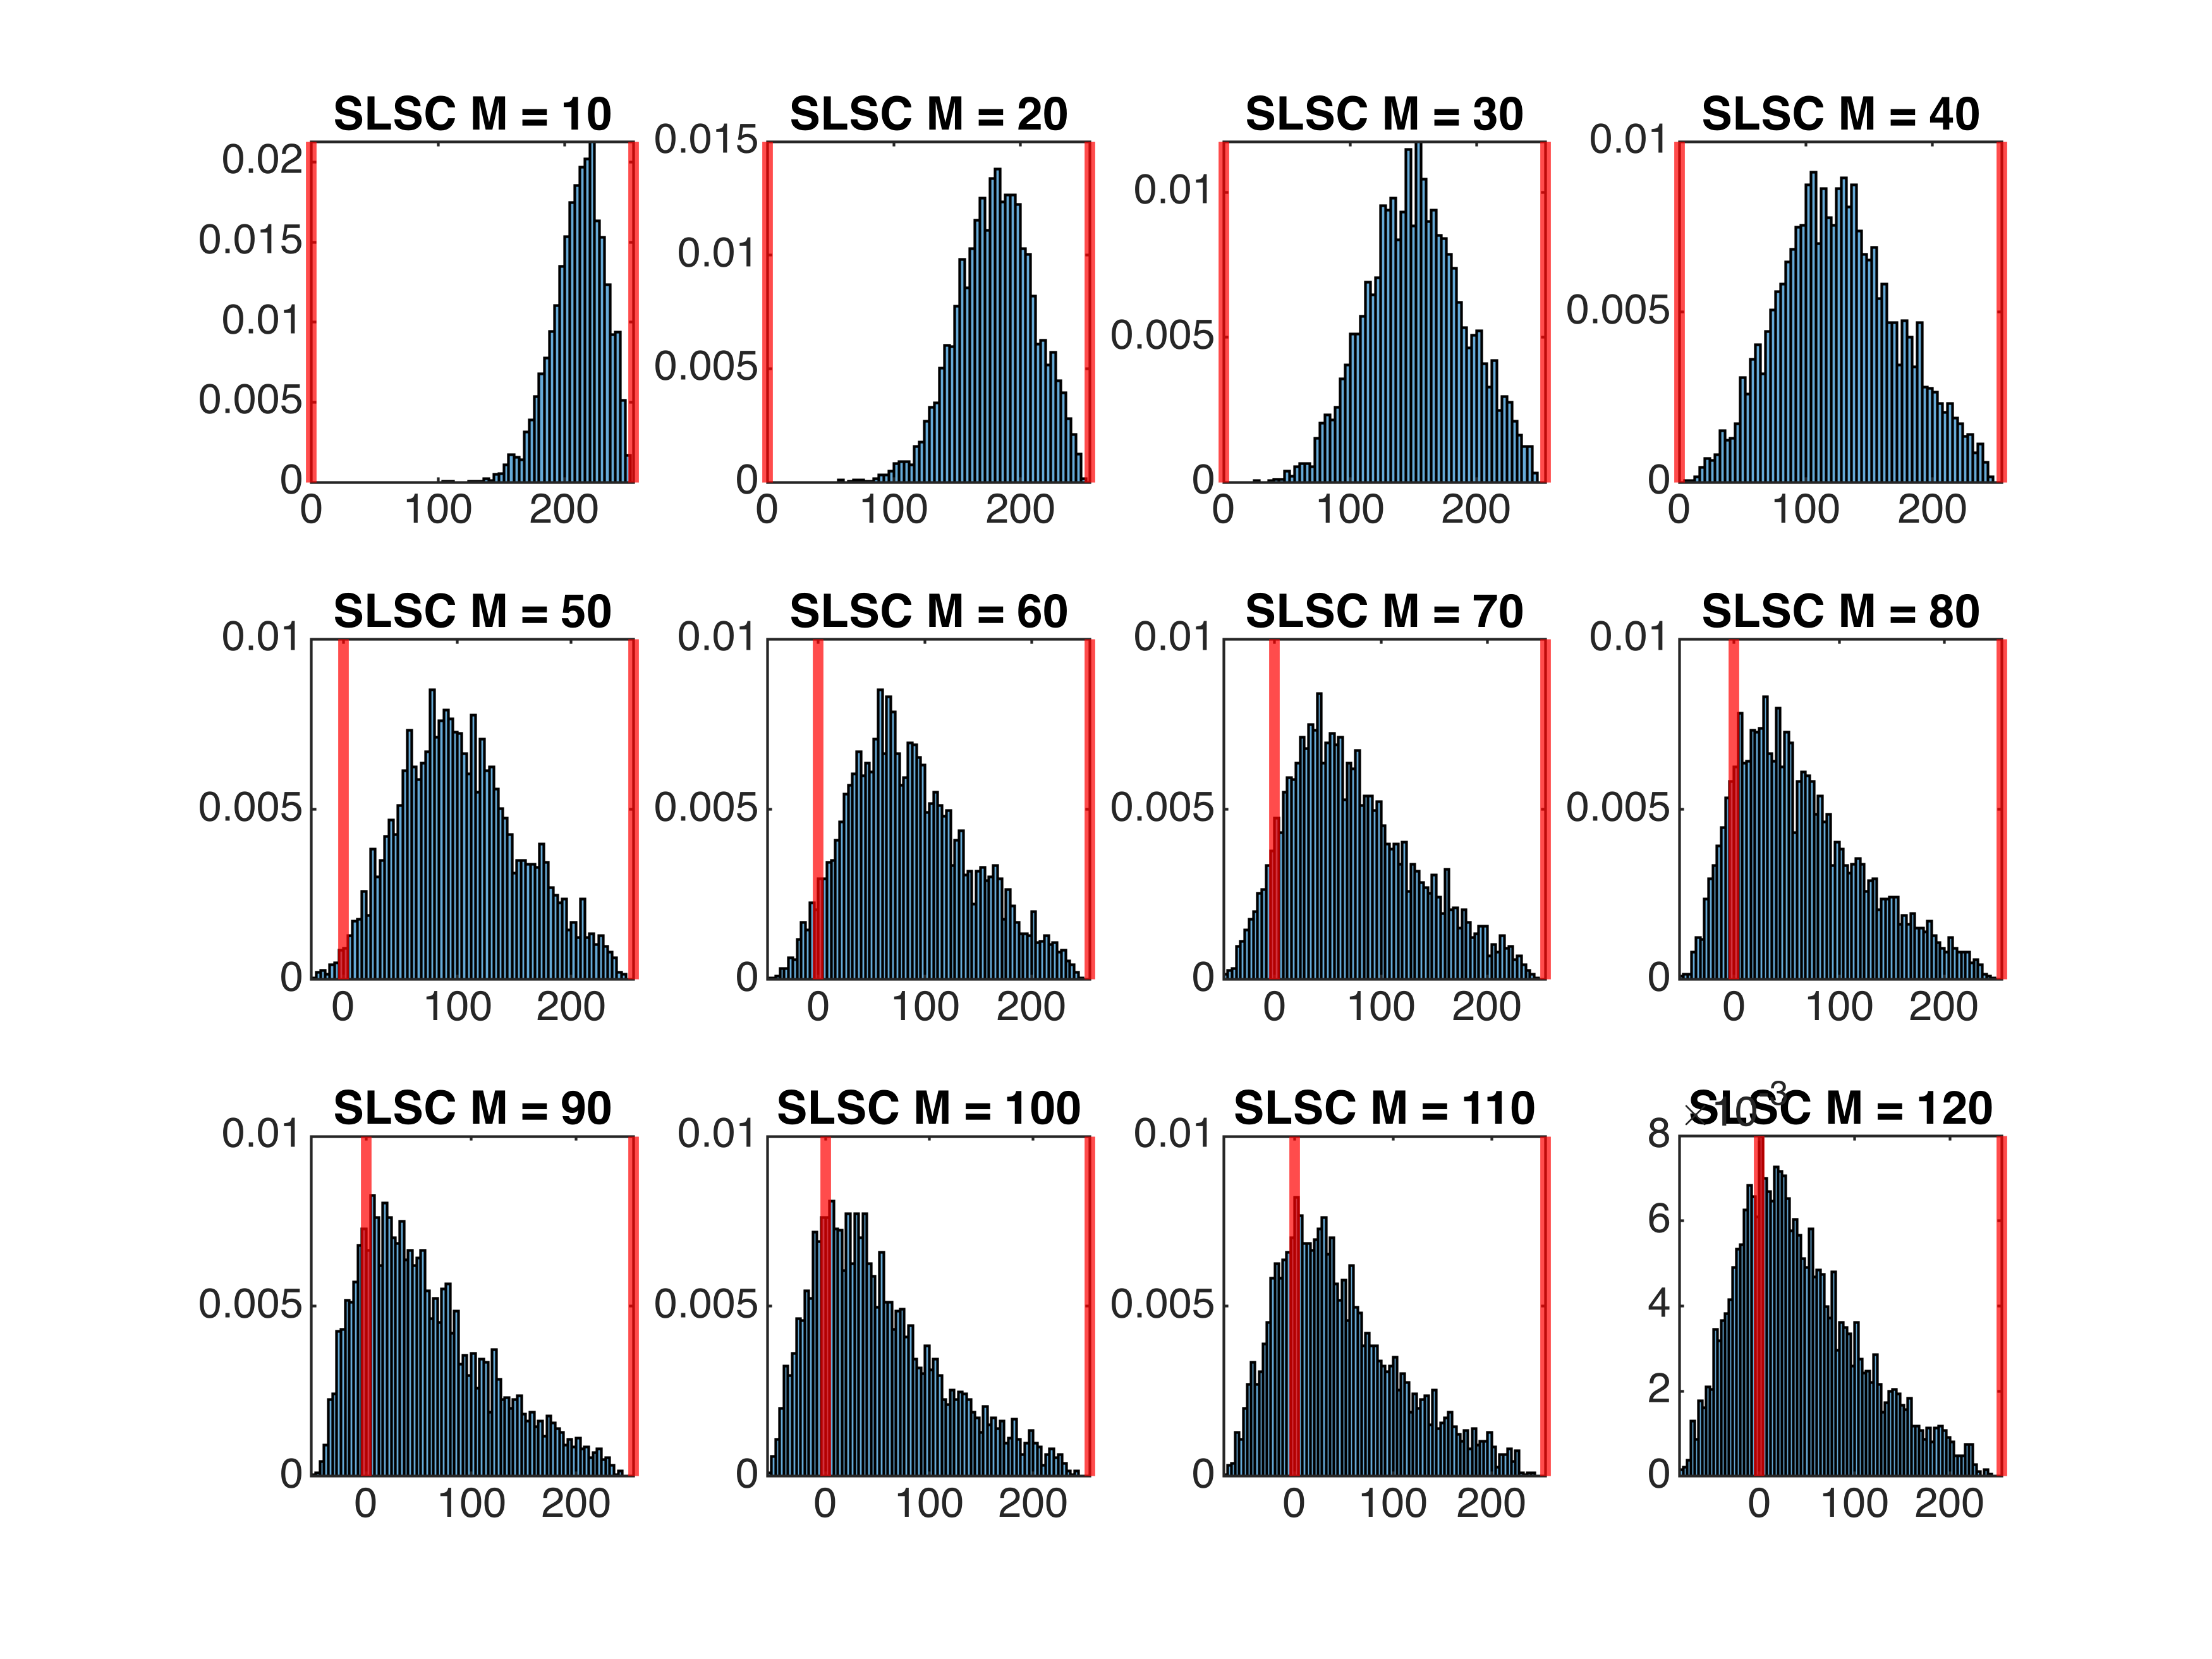

In [17]:
% figure(1) slsc_data.plot(subplot(122),['SLSC M = ',num2str(slsc.maxM)],[],'none'); caxis([0 1])
% slsc_data.plot([],['SLSC M = ',num2str(slsc.maxM)],[],'none');
fig_slsc=figure(WindowState="maximized");
fig_slsc_hist=figure(WindowState="maximized");
for i=1:12
    slsc_res=mean(slsc.slsc_values(:,:,1:10*i),3);
    slsc_wind=slsc_res(lims(2):lims(4), lims(1):lims(3));

    figure(fig_slsc);subplot(3,4,i);
    imagesc(slsc_res); colormap gray; colorbar; clim([0 1]);hold on;
    rectangle(Position=[lims(1:2) lims(3)-lims(1) lims(4)-lims(2)],EdgeColor='r'); % [x y w h]
    title(['SLSC M = ',num2str(10*i)]);

    figure(fig_slsc_hist);subplot(3,4,i);
    histogram(255*slsc_wind,Normalization='pdf',BinWidth=4);%xlim([0 255]);
    xline(0,Color='r',LineWidth=2);xline(255,Color='r',LineWidth=2);xlim([-inf 255]);
    title(['SLSC M = ',num2str(10*i)]);
end